# Reactome_GNN Demo

This notebook shows how to obtain GNN-generated embeddings for nodes in the human pathway network.

In [1]:
import pickle
import torch
import dgl
from reactome_gnn import utils, model

Using backend: pytorch


## Embeddings of a single graph

Specify the list of markers and the threshold p-value.

In [2]:
markers = ['RAS', 'MAP', 'IL10', 'EGF', 'EGFR', 'STAT']
p_value = 0.05
study = 'demo'

Create network from the markers and with specified p-value threshold, given the name of the study. This function first runs the enrichment analysis on the human pathway network and returns the significant nodes. This information is then used to create the graph.

In [3]:
graph = utils.create_network_from_markers(markers, p_value, study)

The main class attribute of the returned graph is `graph.graph_nx` which is a `NetworkX.DiGraph` object---a directed graph where each node has a weight and a significance. Weight is the p-value returned by the enrichment analysis, and significance is a string stating whether the pathway in the network is significant or not. Significant pathways are those that have p-value lower than the specified threshold, in this case 0.05.

For example, let's take a look at the nodes corresponding to R-HSA-1358803 and R-HSA-15869 pathways:

In [4]:
graph.graph_nx.nodes['R-HSA-1358803']

{'stId': 'R-HSA-1358803',
 'name': 'Downregulation of ERBB2:ERBB3 signaling',
 'weight': 0.0109,
 'significance': 'significant'}

In [5]:
graph.graph_nx.nodes['R-HSA-15869']

{'stId': 'R-HSA-15869',
 'name': 'Metabolism of nucleotides',
 'weight': 0.161,
 'significance': 'non-significant'}

We notice that R-HSA-1358803 corresponds to "Downregulation of ERBB2:ERBB3 signaling", and is significant in the network created with the markers specified above (its p-value is 0.0109 which is less than 0.05). On the other hand, R-HSA-15869 corresponds to "Metabolism of nucleotides" which is non-significant in this network (its p-value is 0.161).

Next we want to do is create an embedding of that graph. But in order to do that, graph should be in the DGL format.

In [6]:
graph_dgl = utils.nx_to_dgl(graph.graph_nx)
graph_dgl

Graph(num_nodes=16050, num_edges=16850,
      ndata_schemes={'weight': Scheme(shape=(), dtype=torch.float32), 'significance': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

We also need a GNN model which will produce the embeddings. Since we want the model to be reusable at any given time, the parameters of the model have to be saved to the disk and loaded upon model initialization. The demo model that is already saved is a 5-layers Graph Convolutional Network (GCN) and creates the the embeddings with latent dimension of 16.

The GCN is chosen because it is a relatively "lightweight" model that was proven to have good performance on various graph-related tasks. For example, even when comparing an untrained GCN network against DeepWalk on semi-supervised node classification task, untrained GCN had superior performance! This means that it can more successfully leverage the topology of a graph and create meaningful representation than the traditional methods.

First let's use a pretrained model which is saved as `data/example/models/model.pth`.

In [7]:
net = model.GCNModel(dim_latent=16, num_layers=5)
net.load_state_dict(torch.load('data/example/models/model.pth'))

print(net)

GCNModel(
  (linear): Linear(in_features=1, out_features=16, bias=True)
  (conv_0): GraphConv(in=16, out=16, normalization=both, activation=None)
  (relu): LeakyReLU(negative_slope=0.01)
  (layers): ModuleList(
    (0): GraphConv(in=16, out=16, normalization=both, activation=None)
    (1): GraphConv(in=16, out=16, normalization=both, activation=None)
    (2): GraphConv(in=16, out=16, normalization=both, activation=None)
    (3): GraphConv(in=16, out=16, normalization=both, activation=None)
  )
  (predict): Linear(in_features=16, out_features=1, bias=True)
)


In [8]:
embeddings = net(graph_dgl).detach()
print(embeddings.shape)
embeddings

torch.Size([16050, 16])


tensor([[ 0.0095,  0.0056, -0.0259,  ..., -0.0293,  0.0031,  0.0340],
        [ 0.0095,  0.0056, -0.0259,  ..., -0.0293,  0.0031,  0.0340],
        [ 0.0089,  0.0053, -0.0244,  ..., -0.0275,  0.0027,  0.0317],
        ...,
        [ 0.0142,  0.0084, -0.0389,  ..., -0.0442,  0.0047,  0.0511],
        [ 0.0159,  0.0094, -0.0435,  ..., -0.0495,  0.0053,  0.0571],
        [ 0.0155,  0.0088, -0.0432,  ..., -0.0478,  0.0050,  0.0564]])

This tensor has a shape 16050 x 16, which means that each row represents the embedding of one node, as there are 16050 nodes in the pathway network, and each of these embeddings is 16-dimensional (as specified when initializing the model).

To find the embeddings of some specific pathways, e.g. R-HSA-1358803, we have to load some auxilary information. We can also fetch embeddings of pathways by specifying their name, not only stId.

In [9]:
name_to_id = pickle.load(open('data/example/info/name_to_id.pkl', 'rb'))
sorted_stid_list = pickle.load(open('data/example/info/sorted_stid_list.pkl', 'rb'))

Here, `name_to_id` is a dictionary which maps each pathway name to its stId, and sorted_stid_list is, as the name states, the sorted list of all the stIds in the network. This is necessary due to how DGL stores the nodes when converting the network from the NetworkX format. Let's first obtain the embedding of R-HSA-1358803:

In [10]:
idx = sorted_stid_list.index('R-HSA-1358803')
embeddings[idx]

tensor([ 6.3725e-04,  6.1199e-04,  9.7838e-04,  5.4713e-04, -1.3931e-03,
         3.6057e-05, -4.5174e-05,  6.1824e-04, -6.0032e-05,  6.6200e-04,
        -1.1824e-04,  7.9940e-04, -1.4857e-03, -9.1328e-04,  9.0162e-04,
        -3.8281e-04])

Let's now get the embedding of the pathway "Metabolism of nucleotides":

In [11]:
stid = name_to_id['Metabolism of nucleotides']
idx = sorted_stid_list.index(stid)
embeddings[idx]

tensor([ 1.9431e-04,  2.2929e-04, -3.3696e-04,  2.0422e-04, -1.3896e-03,
        -9.8339e-05,  2.3732e-04,  3.5490e-05, -3.4470e-04,  6.5490e-04,
        -5.2909e-04,  5.1950e-04, -2.6007e-04, -6.7819e-04,  6.6426e-05,
         5.4241e-04])

## Working with datasets

Steps above are useful when we are working with a single pathway network, but the procedure could be cumbersome when we need to work with several networks. That's where we can use datasets to automate part of the process. Here we will work with a toy dataset consisting of four different pathways, generated by lighting up pathways specified via their name. The networks are called A, B, C, and D, and the relations between them is such that $A = D$, $A \& D \subset C$, $B \cap C = \emptyset$.

In [12]:
graph_A, graph_B, graph_c, graph_D, _ = utils.create_toy_study_with_names(data_dir='data/example')
embedding_dict = utils.create_embeddings(data_dir='data/example')

What happens under the hood is that a PathwayDataset is created. This is a DGL dataset that makes processing raw graphs and loading DGL graphs easier. Creating this dataset is not mandatory, but helps when working with multiple graphs.

In [13]:
from reactome_gnn import dataset

ds = dataset.PathwayDataset(root='data/example')

graph, name = ds[0]
print(name)
print(graph)

study_A.dgl
Graph(num_nodes=16050, num_edges=16850,
      ndata_schemes={'significance': Scheme(shape=(), dtype=torch.float32), 'weight': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})


But let's return to creating the embeddings. What's inside the embedding_dict?

In [14]:
embedding_dict

{'study_A.dgl': tensor([[ 0.0094,  0.0057, -0.0255,  ..., -0.0291,  0.0030,  0.0336],
         [ 0.0094,  0.0057, -0.0255,  ..., -0.0291,  0.0030,  0.0336],
         [ 0.0096,  0.0054, -0.0268,  ..., -0.0297,  0.0031,  0.0350],
         ...,
         [ 0.0143,  0.0083, -0.0393,  ..., -0.0442,  0.0047,  0.0516],
         [ 0.0160,  0.0094, -0.0440,  ..., -0.0496,  0.0052,  0.0577],
         [ 0.0154,  0.0087, -0.0429,  ..., -0.0475,  0.0050,  0.0560]]),
 'study_B.dgl': tensor([[ 0.0098,  0.0055, -0.0272,  ..., -0.0301,  0.0032,  0.0355],
         [ 0.0098,  0.0055, -0.0272,  ..., -0.0301,  0.0032,  0.0355],
         [ 0.0087,  0.0053, -0.0235,  ..., -0.0271,  0.0027,  0.0306],
         ...,
         [ 0.0146,  0.0083, -0.0407,  ..., -0.0451,  0.0048,  0.0532],
         [ 0.0164,  0.0093, -0.0457,  ..., -0.0507,  0.0053,  0.0598],
         [ 0.0155,  0.0088, -0.0432,  ..., -0.0479,  0.0050,  0.0565]]),
 'study_C.dgl': tensor([[ 0.0095,  0.0057, -0.0255,  ..., -0.0293,  0.0031,  0.0337],


We see that we have obtained a dictionary, where keys are the names of the graphs, and the values are the embedding tensors for the corresponding graphs. The graph E is created for the validation purposes during the model training. We can obtain the embedding of each node in the same way as we did above, in the case of a single graph.

### Comparing the embeddings

To compare the embeddings obtained above, we use Canonical Correlation Analysis (CCA).  First we specify the targets Y for each graph, which specify which nodes are significant and which are not. Then we fit the data on the CCA model from scikit-learn. This fitted model can be used to transform embedding data and compare embeddings of nodes across different graphs. This is all done inside the `utils.fit_cca_on_toy_data()` function, so we can simply call it like this:

In [15]:
cca = utils.fit_cca_on_toy_data('data/example')

But for the sake of ilustration, we show here how it is done step-by-step so that the code can be reused with new data.

In [16]:
# Note: We do not fit graph D, since it is equivalent to graph A

from sklearn.cross_decomposition import CCA

study_A = ["Signaling by WNT", "WNT ligand biogenesis and trafficking", "Degradation of beta-catenin by the destruction complex",
           "TCF dependent signaling in response to WNT", "Beta-catenin independent WNT signaling"]
study_B = ["Autophagy", "Macroautophagy", "Chaperone Mediated Autophagy", "Late endosomal microautophagy"]
study_C = ["Signal Transduction", "Signaling by NOTCH", "Signaling by NOTCH1", "Signaling by NOTCH2", "Signaling by NOTCH3",
           "Signaling by NOTCH4", "Activated NOTCH1 Transmits Signal to the Nucleus",
           "NOTCH1 Intracellular Domain Regulates Transcription", "Signaling by WNT", "WNT ligand biogenesis and trafficking",
           "Degradation of beta-catenin by the destruction complex", "TCF dependent signaling in response to WNT",
           "Beta-catenin independent WNT signaling"]

emb_A = embedding_dict['study_A.dgl']
emb_B = embedding_dict['study_B.dgl']
emb_C = embedding_dict['study_C.dgl']
emb_D = embedding_dict['study_D.dgl']

name_to_id = pickle.load(open('data/example/info/name_to_id.pkl', 'rb'))
sorted_stid_list = pickle.load(open('data/example/info/sorted_stid_list.pkl', 'rb'))

indices_A = [sorted_stid_list.index(id) for name, id in name_to_id.items() if name in study_A]
indices_B = [sorted_stid_list.index(id) for name, id in name_to_id.items() if name in study_B]
indices_C = [sorted_stid_list.index(id) for name, id in name_to_id.items() if name in study_C]

y_A = torch.tensor([1.0 if i in indices_A else 0.0 for i in range(len(sorted_stid_list))]).unsqueeze(-1)
y_B = torch.tensor([1.0 if i in indices_B else 0.0 for i in range(len(sorted_stid_list))]).unsqueeze(-1)
y_C = torch.tensor([1.0 if i in indices_C else 0.0 for i in range(len(sorted_stid_list))]).unsqueeze(-1)

cca = CCA(1)
cca.fit(emb_A, y_A).fit(emb_B, y_B).fit(emb_C, y_C)
cca

CCA(n_components=1)

Next thing we need to do is transform the embedding tensors:

In [17]:
emb_A_t = cca.transform(emb_A)
emb_B_t = cca.transform(emb_B)
emb_C_t = cca.transform(emb_C)
emb_D_t = cca.transform(emb_D)

Finally, we can compare the obtained embeddings. For example, let's compare the embeddings of nodes that correspond to pathway "WNT ligand biogenesis and trafficking". This pathway is present in graphs A, C, and D, but not in B.

In [18]:
stid = name_to_id['WNT ligand biogenesis and trafficking']
idx = sorted_stid_list.index(stid)

print(emb_A_t[idx], emb_B_t[idx], emb_C_t[idx], emb_D_t[idx])

[-2.3808361e-05] [-2.06522513e-05] [-2.3808361e-05] [-2.3808361e-05]


We can see that the values returned are identical in the case of A, C, and D. This is due to similarity of the three pathway networks and the fact that the specified pathway is significant in all three of them. We also notice that the value is relatively different in the case of network B in which this pathway is not significant. This shows that the embeddings are consistent within this dataset. Furthermore, we epxect that a network with a higher expressive power would be able to discriminate better between different embeddings.

## Training a new model

Let's now train a new model from scratch! First we need to define hyperparameters which will be used. The available hyperparameters are:
- `num_epochs` - For how many epochs will the model be trained
- `dim_latent` - Dimension of the produced embeddings
- `num_layers` - Number of hidden GCN layers in the network
- `batch_size` - Number of examples in a mini-batch
- `device`     - CUDA or CPU
- `lr`         - Learning rate

The hyperparameters are stored in a dictionary. Let's define a network with 4 GCN layers, and let the embedding dimenion be 32. We will train the network for 200 epochs. The batch size, due to a small number of training dataset, will be one, and learning rate will be 5e-4.

In [24]:
hyperparameters = {
        'num_epochs': 200,
        'dim_latent': 32,
        'num_layers': 4,
        'batch_size': 1,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'lr': 5e-4,
}

Training the model can be done separately by calling a `train` function in the `train.py` module. The loss plot will be saved to the disk, as well as the trained model. However, this is also done automatically in the `utils.create_embeddings` function, if appropriate arguments are passed. We can take a look at that function to see which arguments we need.

In [20]:
help(utils.create_embeddings)

Help on function create_embeddings in module reactome_gnn.utils:

create_embeddings(load_model=True, save=False, data_dir='demo/data/example', hyperparams=None, plot=True)
    Create embeddings for all the graphs stored on the disk.
    
    First the Pathway dataset is created which takes all the graphs
    stored in the 'raw' directory, processes them, and stores them in
    the 'processed' directory. Each graph is fed to the model with
    specified latent dimension and number of GCN layers, which returns
    the embedding of that graph. All the embeddings are saved on the
    disk in the 'embeddings' directory.
    
    Parameters
    ----------
    load_model : bool, optional
        Whether to load an old model or create a new one
    save : bool, optional
        Whether to save the created embeddings to the disk, default: False
    data_dir : str, optional
        Relative path to where the data is stored
    hyperparams : dict, optional
        In case no hyperparameter dictio

We can see that `load_model` should be set to `False` (since we want to train a new model, not load a pretrained one), and that we should pass the defined dictionary as `hyperparams`. Running this function will also run the training loop, which will output training and validation loss every 20 epochs, as well as the F1-score to see how accurately we can predict the significance from the weights and the topology of the graph. Finally, we plot how the loss and F1-score change over epochs.

Epoch: 20	Training loss:		9.598915539754671e-05
Epoch: 20	Validation loss:	0.00011797092338383663
Epoch: 20	F1 score:		0.0

Epoch: 40	Training loss:		1.5704351767453772e-05
Epoch: 40	Validation loss:	3.1787540308414464e-05
Epoch: 40	F1 score:		0.05273321449792038

Epoch: 60	Training loss:		7.354884978383325e-06
Epoch: 60	Validation loss:	1.8445607992134683e-05
Epoch: 60	F1 score:		0.2104129530600119

Epoch: 80	Training loss:		4.610541221694575e-06
Epoch: 80	Validation loss:	1.3162295573465599e-05
Epoch: 80	F1 score:		0.25425963488843817

Epoch: 100	Training loss:		3.3583439194018183e-06
Epoch: 100	Validation loss:	1.0290084233588459e-05
Epoch: 100	F1 score:		0.32992470492470494

Epoch: 120	Training loss:		2.674771478083926e-06
Epoch: 120	Validation loss:	8.485848226769122e-06
Epoch: 120	F1 score:		0.38278985507246377

Epoch: 140	Training loss:		2.283150870141526e-06
Epoch: 140	Validation loss:	7.152752019123909e-06
Epoch: 140	F1 score:		0.35580963154492573

Epoch: 160	Training loss:		2

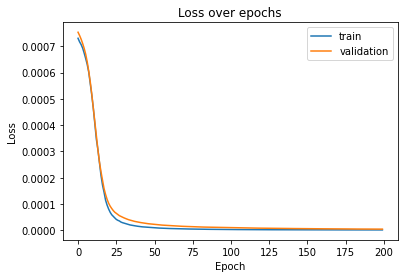

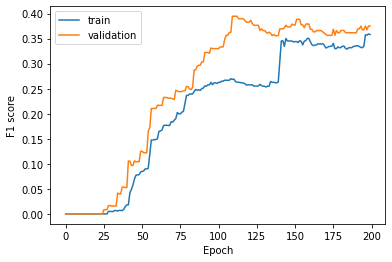

In [25]:
embedding_dict = utils.create_embeddings(data_dir='data/example', load_model=False, hyperparams=hyperparameters)

We can notice how the loss drops significantly during training, and that F1-score rises to almost 0.4, but doesn't stop there. This means that if we trained the network for longer the F1-score could rise even higher and the embeddings could get more descriptive. This is also a case if we used a network with more layers and produced the embeddings with higher dimensionality. This all falls under the cathegory of hyperparameter optimization, which is an active research area.

Since these embeddings are not stored on the disk (we didn't specify `save=True`), let's perform CCA analysis manually once again.

In [26]:
emb_A = embedding_dict['study_A.dgl']
emb_B = embedding_dict['study_B.dgl']
emb_C = embedding_dict['study_C.dgl']
emb_D = embedding_dict['study_D.dgl']

name_to_id = pickle.load(open('data/example/info/name_to_id.pkl', 'rb'))
sorted_stid_list = pickle.load(open('data/example/info/sorted_stid_list.pkl', 'rb'))

indices_A = [sorted_stid_list.index(id) for name, id in name_to_id.items() if name in study_A]
indices_B = [sorted_stid_list.index(id) for name, id in name_to_id.items() if name in study_B]
indices_C = [sorted_stid_list.index(id) for name, id in name_to_id.items() if name in study_C]

y_A = torch.tensor([1.0 if i in indices_A else 0.0 for i in range(len(sorted_stid_list))]).unsqueeze(-1)
y_B = torch.tensor([1.0 if i in indices_B else 0.0 for i in range(len(sorted_stid_list))]).unsqueeze(-1)
y_C = torch.tensor([1.0 if i in indices_C else 0.0 for i in range(len(sorted_stid_list))]).unsqueeze(-1)

cca = CCA(1)
cca.fit(emb_A, y_A).fit(emb_B, y_B).fit(emb_C, y_C)

emb_A_t = cca.transform(emb_A)
emb_B_t = cca.transform(emb_B)
emb_C_t = cca.transform(emb_C)
emb_D_t = cca.transform(emb_D)

In [27]:
stid = name_to_id['WNT ligand biogenesis and trafficking']
idx = sorted_stid_list.index(stid)

print(emb_A_t[idx], emb_B_t[idx], emb_C_t[idx], emb_D_t[idx])

[6.6880423e-06] [4.83995163e-06] [6.6880423e-06] [6.6880423e-06]


We see that the values of A, C, and D are still the same as they should be. We also notice that the difference between the value of B is significantly more different form the other values than it was in the previous case. This could mean that this network has a higher expressive power and it produces better embeddings for downstream tasks, which remain consistent within the dataset.